In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
import scipy
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
from scipy.stats import zscore
#from umap import UMAP
#from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/eval_strict_MVG_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '01_eval.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score_strict'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred_strict'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_torchvison_resnet18/config.yaml'

In [7]:
#score = pd.read_csv(f'{OUT_SCORE_DIR}/{machine_types[0]}_score.csv', index_col=0)

In [8]:
#score.loc['h_mean']['pAUC']

# load data

In [9]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [10]:
data_types = ['train', 'valid_source', 'valid_target']

In [11]:
?ext_data

Object `ext_data` not found.


In [12]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

In [13]:
# for train datasets
def get_target_names(wav_names):
    target_names = []
    for wav_name in wav_names:
        if 'target' in wav_name:
            target_names.append(wav_name)
    
    return target_names

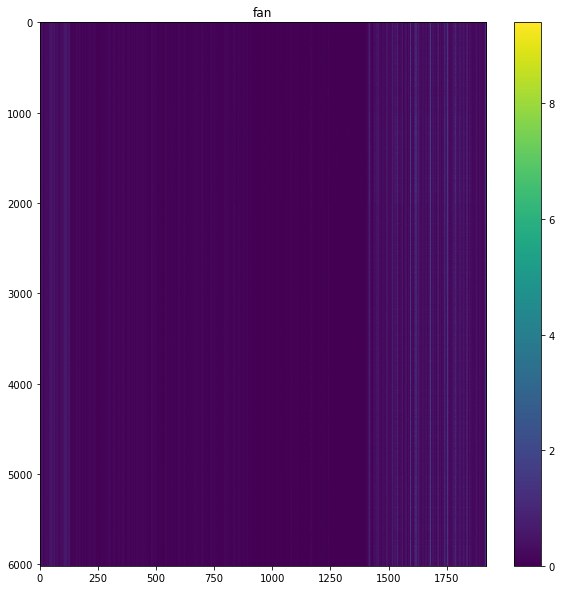

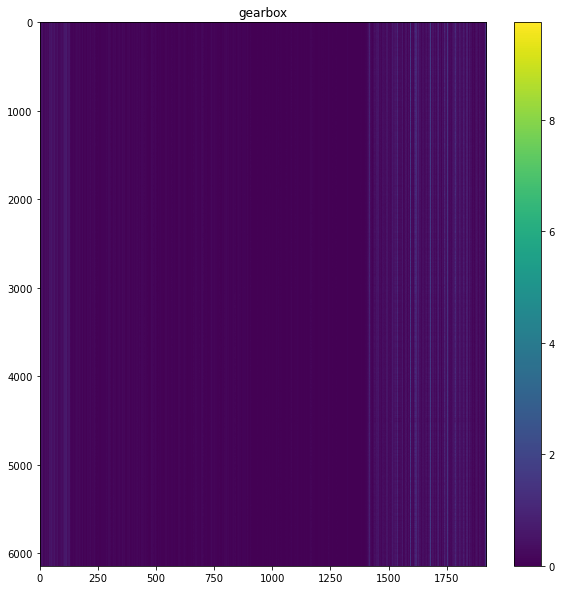

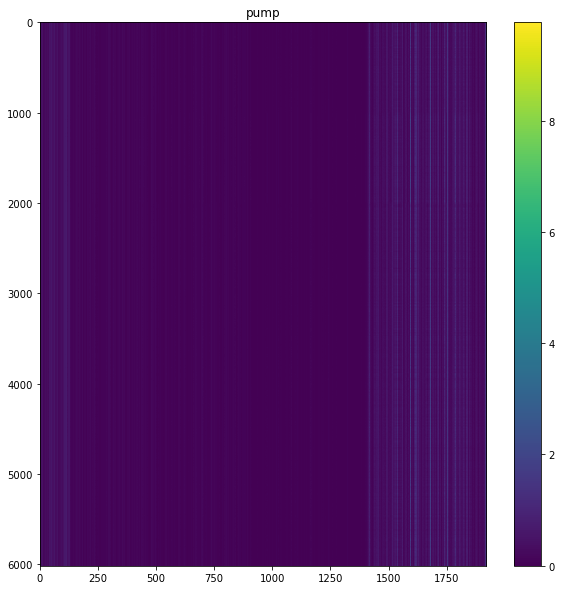

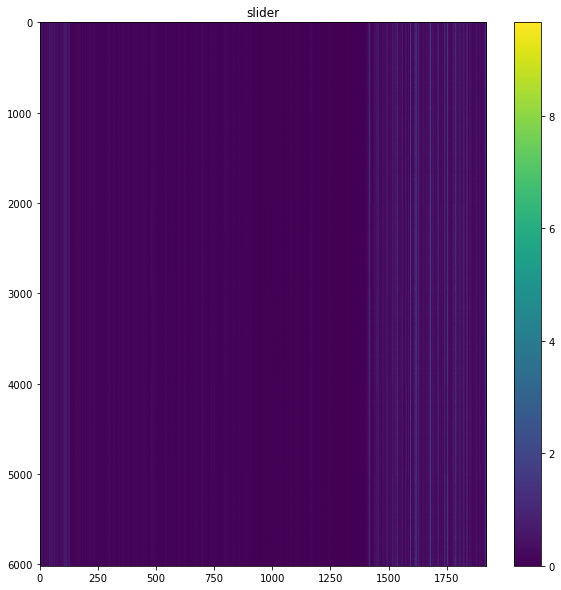

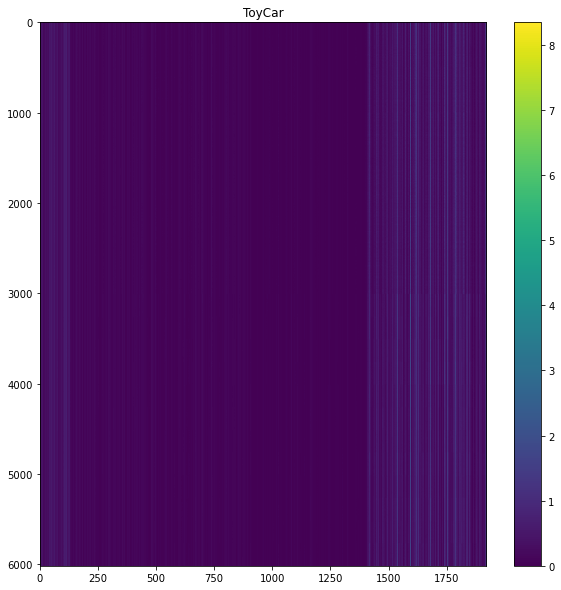

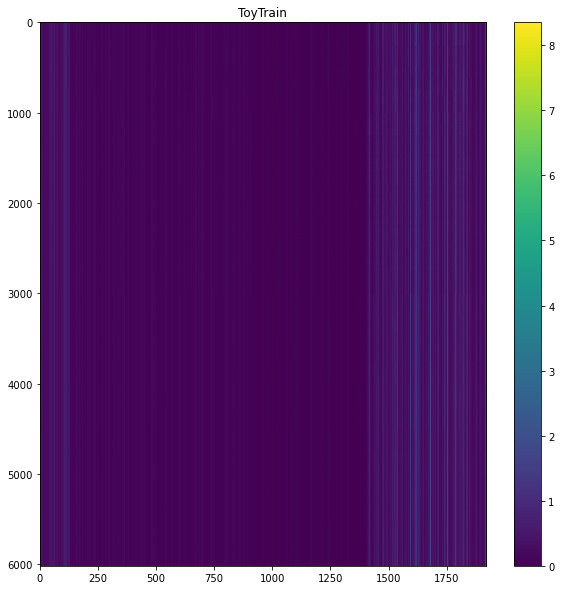

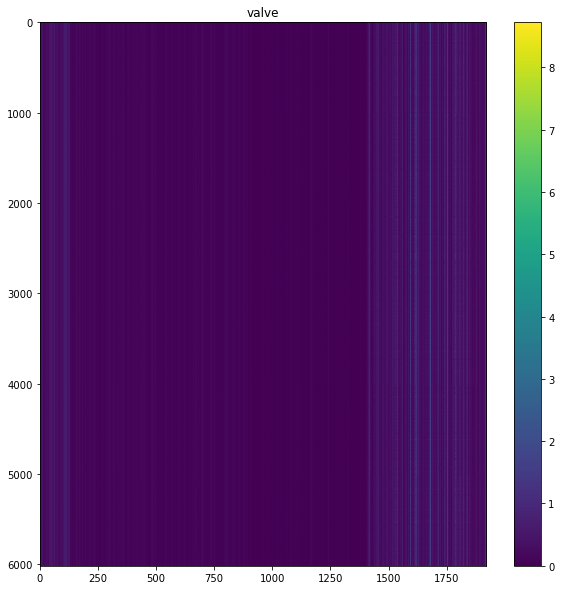

In [14]:
for machine_type in machine_types:
    data = load_ext_data(machine_type)
    plt.figure(figsize=(10,10))
    plt.imshow(data['train']['features'], aspect='auto')
    plt.title(machine_type)
    plt.colorbar()
    plt.show()

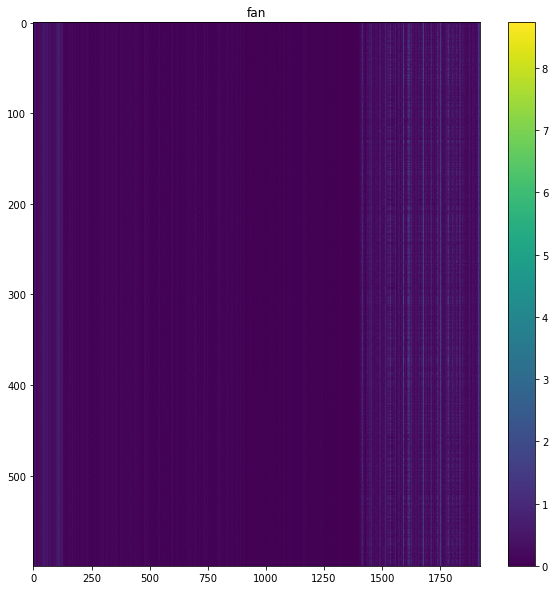

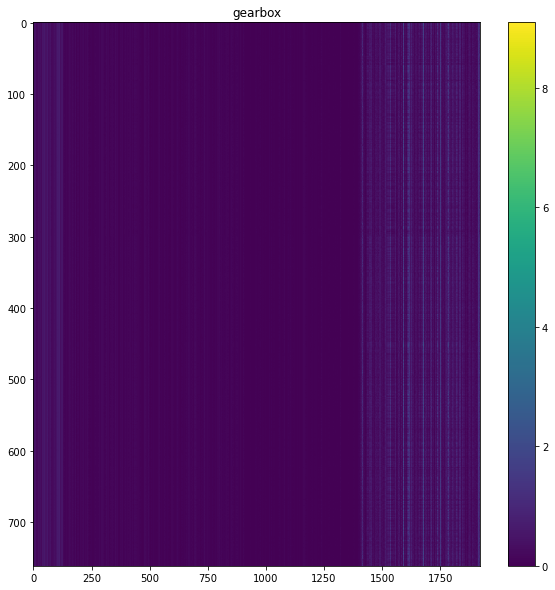

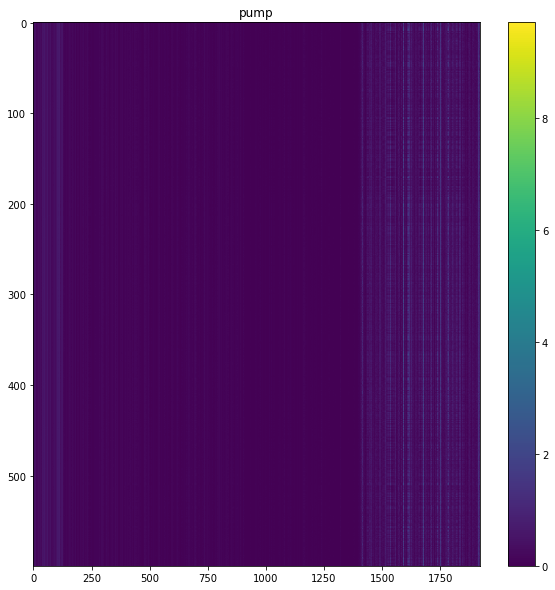

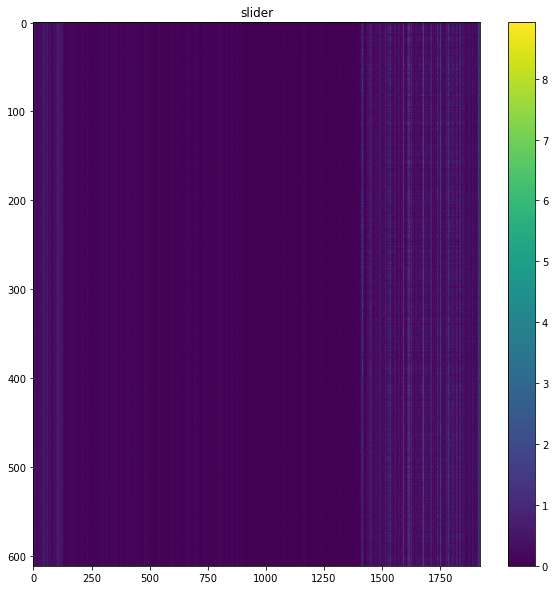

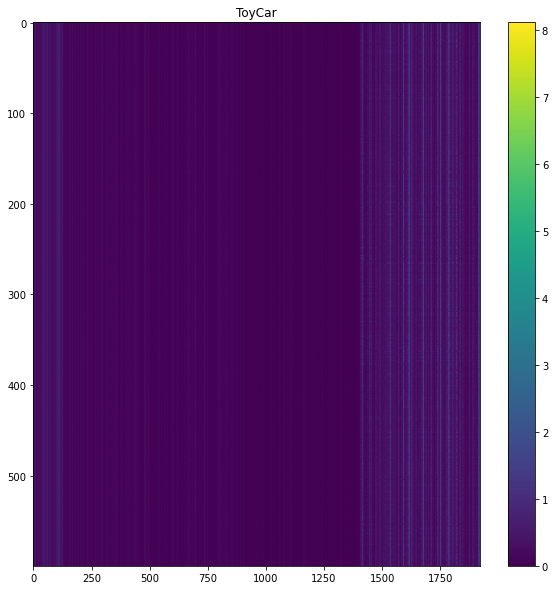

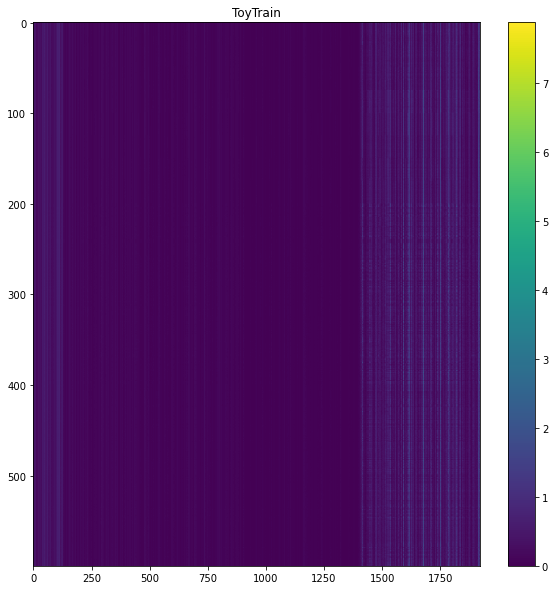

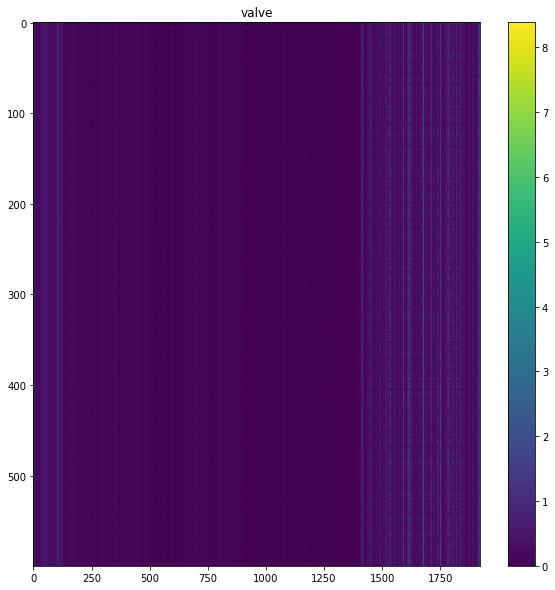

In [15]:
for machine_type in machine_types:
    data = load_ext_data(machine_type)
    plt.figure(figsize=(10,10))
    plt.imshow(data['valid_source']['features'], aspect='auto')
    plt.title(machine_type)
    plt.colorbar()
    plt.show()

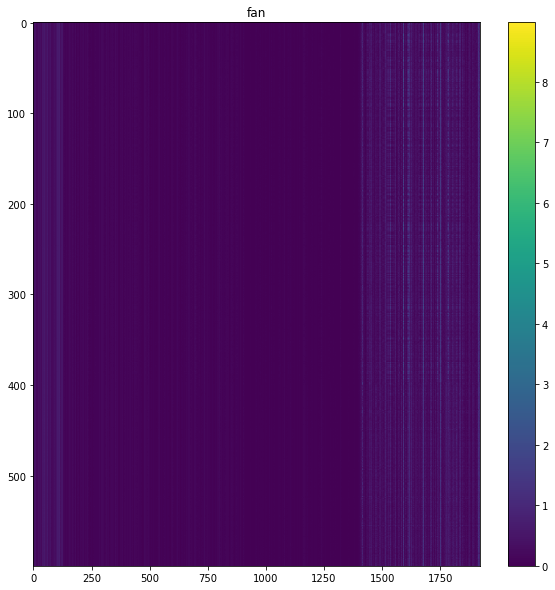

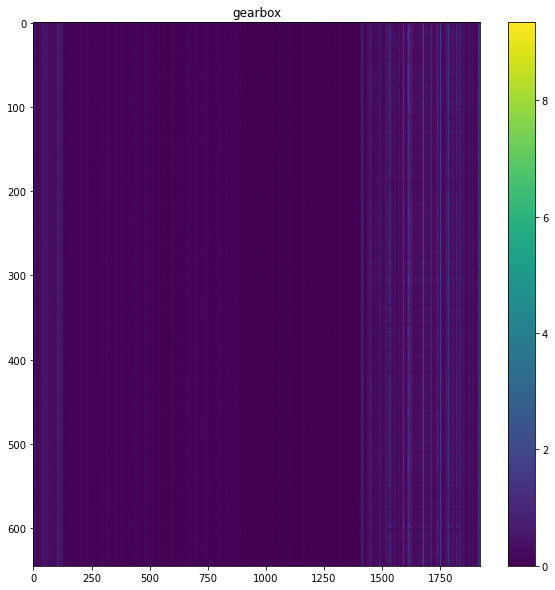

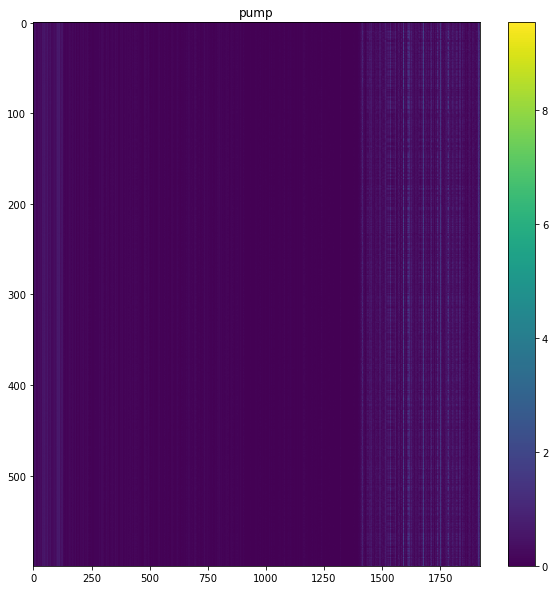

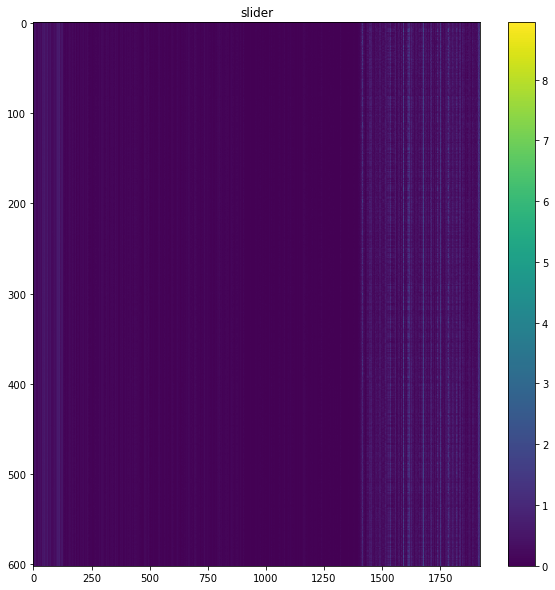

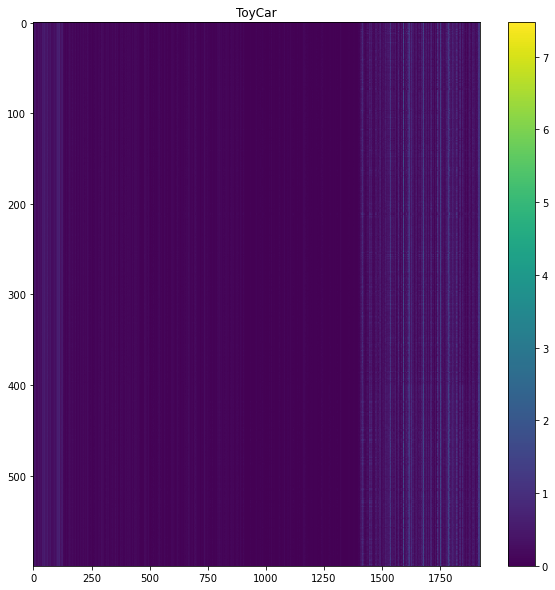

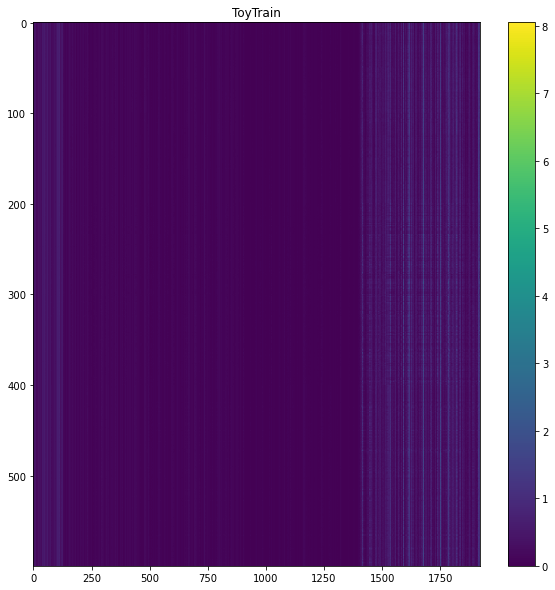

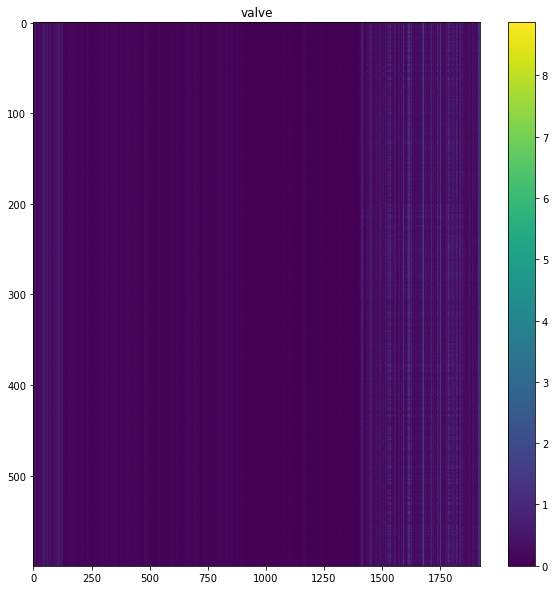

In [16]:
for machine_type in machine_types:
    data = load_ext_data(machine_type)
    plt.figure(figsize=(10,10))
    plt.imshow(data['valid_target']['features'], aspect='auto')
    plt.title(machine_type)
    plt.colorbar()
    plt.show()

# evaluation

## calc MVG (multivariate Gaussian)

In [17]:
com.tic()

MVG = {}
for machine_type in machine_types:
    MVG[machine_type] = {}
    ext_data = load_ext_data(machine_type)
    section_types = com.get_section_types(ext_data['train']['wav_names'])
    
    for section in np.unique(section_types):
        MVG[machine_type][section] = {}
        idx = np.where(section_types == section)
        per_section_samples = ext_data['train']['features'][idx]
        per_section_mean = per_section_samples.mean(axis=0)
        cov_estimator = LedoitWolf()
        cov_estimator.fit(per_section_samples)
        per_section_cov = cov_estimator.covariance_
        MVG[machine_type][section]['mean'] = per_section_mean
        MVG[machine_type][section]['cov'] = per_section_cov

com.toc()

elapsed time: 13.644635201 [sec]


In [18]:
MVG[machine_type][0]['mean']

array([3.8955417e-01, 4.5704022e-01, 9.9516510e-05, ..., 2.7438898e+00,
       1.0547529e+00, 2.4980579e-01], dtype=float32)

## estimate

In [19]:
from IPython.display import display

In [20]:
def get_score_perID(describe_df, max_fpr=0.1):
    # ユニークsectionを取得、昇順ソート
    sections = np.sort(describe_df['section_types'].unique())

    for section in sections:
        per_section_df = describe_df[describe_df['section_types'] == section]
        per_section_AUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'])
        per_section_pAUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'], max_fpr=max_fpr)
        # column = [AUC,pAUC], row = index
        score_df = pd.DataFrame(np.stack([per_section_AUC, per_section_pAUC]), index=['AUC', 'pAUC']).T
        # indexをsectionナンバーにrename
        # column = [AUC,pAUC], row = [section]
        score_df.index = [section]
        if section == 0:
            scores_df = score_df.copy()
        else:
            # 結合
            scores_df = scores_df.append(score_df)
    return scores_df

In [21]:
def calc_mahalanobis(mean, cov, samples):
    cov_inv = np.linalg.inv(cov)
    # load data
    dists = [mahalanobis(sample, mean, cov_inv) for sample in samples]
    # np.array
    dists = np.array(dists)
    return dists

## Calc Score

In [22]:
# valid_dataloaderをシャッフルするとバグるの注意

for i, machine_type in enumerate(machine_types):
    logger.info('CALC SCORE')
    logger.info(machine_type)
    # get MVG
    #tr_mean = MVG[machine_type]['mean']
    #tr_cov = MVG[machine_type]['cov']
    # load samples
    ext_data = load_ext_data(machine_type)
    for phase in ['valid_source', 'valid_target']:
        # pred
        samples = ext_data[phase]['features']
        section_types = com.get_section_types(ext_data[phase]['wav_names'])
        for section in np.unique(section_types):
            # get MVG
            tr_mean = MVG[machine_type][section]['mean']
            tr_cov = MVG[machine_type][section]['cov']
            idx = np.where(section_types == section)
            per_section_samples = ext_data[phase]['features'][idx]
            per_preds = calc_mahalanobis(tr_mean, tr_cov, per_section_samples)

            if section == np.unique(section_types)[0]:
                preds = per_preds.copy()
            else:
                preds = np.concatenate([preds, per_preds], axis=0)
        # wavname + pred
        preds_pd = np.stack([np.array(ext_data[phase]['wav_names']), preds], axis=1)
        preds_pd = pd.DataFrame(preds_pd, columns=['wav_name', 'pred'])
        preds_pd.to_csv(OUT_PRED_DIR + f'/pred_{machine_type}_{phase}.csv')
        # dataframe作成
        describe_df = com.get_pred_discribe(labels=ext_data[phase]['labels'],
                                            preds=preds,
                                            section_types=section_types)
        # スコア算出(AUC, pAUC)
        scores_df = com.get_score_per_Section(describe_df, max_fpr=0.1)

        # 結合(source + target)
        if phase == 'valid_source':
            scores_df = scores_df.rename(index=lambda num: 'Source_' + f'{num}')
            all_scores_df = scores_df.copy()
        else:
            scores_df = scores_df.rename(index=lambda num: 'Target_' + f'{num}')
            all_scores_df = all_scores_df.append(scores_df)
            
    # 平均
    mean_df = pd.DataFrame(all_scores_df.mean(axis=0)).T
    mean_df.index = ['mean']
    # 調和平均
    hmean = scipy.stats.hmean(all_scores_df, axis=0)
    hmean_df = pd.DataFrame(hmean, index=['AUC', 'pAUC']).T
    hmean_df.index = ['h_mean']
    # 結合
    all_scores_df = all_scores_df.append(mean_df)
    all_scores_df = all_scores_df.append(hmean_df)
    # 出力
    all_scores_df.to_csv(f'{OUT_SCORE_DIR}/{machine_type}_score.csv')
    # display
    display(all_scores_df)

2021-05-20 16:37:52,603 - 01_eval.py - INFO - CALC SCORE
2021-05-20 16:37:52,604 - 01_eval.py - INFO - fan


,AUC,pAUC
Source_0,0.570300,0.504211
Source_1,0.644400,0.520000
Source_2,0.616900,0.509474
Target_0,0.645900,0.505263
Target_1,0.557600,0.516316
Target_2,0.517400,0.492105
mean,0.592083,0.507895
h_mean,0.588197,0.507733


2021-05-20 16:37:54,660 - 01_eval.py - INFO - CALC SCORE
2021-05-20 16:37:54,671 - 01_eval.py - INFO - gearbox


,AUC,pAUC
Source_0,0.576166,0.542446
Source_1,0.768519,0.538300
Source_2,0.615338,0.531387
Target_0,0.791184,0.597953
Target_1,0.751372,0.576745
Target_2,0.677540,0.571846
mean,0.696686,0.559780
h_mean,0.687073,0.558762


2021-05-20 16:37:56,650 - 01_eval.py - INFO - CALC SCORE
2021-05-20 16:37:56,651 - 01_eval.py - INFO - pump


,AUC,pAUC
Source_0,0.647100,0.570526
Source_1,0.728600,0.566842
Source_2,0.626600,0.555789
Target_0,0.559200,0.514737
Target_1,0.628900,0.497368
Target_2,0.615400,0.534737
mean,0.634300,0.540000
h_mean,0.630446,0.538620


2021-05-20 16:37:58,532 - 01_eval.py - INFO - CALC SCORE
2021-05-20 16:37:58,533 - 01_eval.py - INFO - slider


,AUC,pAUC
Source_0,0.755500,0.574737
Source_1,0.845200,0.660000
Source_2,0.783868,0.666479
Target_0,0.601700,0.529474
Target_1,0.530204,0.539205
Target_2,0.559208,0.578401
mean,0.679280,0.591383
h_mean,0.657983,0.586645


2021-05-20 16:38:00,446 - 01_eval.py - INFO - CALC SCORE
2021-05-20 16:38:00,448 - 01_eval.py - INFO - ToyCar


,AUC,pAUC
Source_0,0.575800,0.484211
Source_1,0.551800,0.498947
Source_2,0.679100,0.512105
Target_0,0.506900,0.508947
Target_1,0.579900,0.511053
Target_2,0.563900,0.506842
mean,0.576233,0.503684
h_mean,0.571860,0.503493


2021-05-20 16:38:02,776 - 01_eval.py - INFO - CALC SCORE
2021-05-20 16:38:02,777 - 01_eval.py - INFO - ToyTrain


,AUC,pAUC
Source_0,0.808300,0.614211
Source_1,0.663000,0.553684
Source_2,0.668900,0.487368
Target_0,0.672200,0.566842
Target_1,0.562600,0.495789
Target_2,0.688600,0.528947
mean,0.677267,0.541140
h_mean,0.669808,0.537744


2021-05-20 16:38:05,070 - 01_eval.py - INFO - CALC SCORE
2021-05-20 16:38:05,070 - 01_eval.py - INFO - valve


,AUC,pAUC
Source_0,0.614200,0.500526
Source_1,0.547900,0.514211
Source_2,0.668400,0.536316
Target_0,0.553700,0.501053
Target_1,0.646100,0.560000
Target_2,0.458600,0.513158
mean,0.581483,0.520877
h_mean,0.572316,0.520047


for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## calc GMM

In [23]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [24]:
ext_data = load_ext_data(machine_types[6])
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ext_data['train']['features'])

NameError: name 'GaussianMixture' is not defined

In [ ]:
gmm.bic(ext_data['train']['features'])

In [ ]:
pred = gmm.predict(ext_data['train']['features'])

In [ ]:
plt.hist(pred)

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [ ]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

In [ ]:
gmm_section_types = gmm.predict(feats)

In [ ]:
sns.distplot(section_types)

In [ ]:
sns.displot(gmm_section_types)